# Evaluation of models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import torchvision.transforms as transforms
# from torchvision import datasets
import torch
# import torch.nn.utils as utils
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Reconstruct import reconstruction_cnn
from Classify import classification_cnn
import confusion_matrix as cm
import wandb_functions as wf

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [15]:
%%time
snr = "noiseless" #noise level in decibels dB
method = "decoder"

# define parameters
params = {
  "dataset": f"MNIST_mura_{snr}_reconstructed_{method}_method",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "p": 23, # size of array (has to be prime)
  "kind": "classification",
  "suffix": "OG_mnist_50epochs",#f"{snr}dB",#_reconstructed_{method}_method",#f"{snr}dB_reconstructed_{method}_method",#"mura_noiseless",
  "SNR": snr,
  "method": method,
}

# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])
params['model'] = params['kind']+'_' + params['suffix'] 
params['model_save_path'] = path + f"models/{params['kind']}/{params['model']}.pth"

# define CNN and get data
device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

model = classification_cnn(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate']) 

# Load trained model
print("Loading model: ", params['model_save_path'])
model.load_state_dict(torch.load(params['model_save_path']))

Loading model:  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/models/classification/classification_OG_mnist_50epochs.pth
CPU times: user 7.31 ms, sys: 1.86 ms, total: 9.17 ms
Wall time: 7.87 ms


<All keys matched successfully>

In [16]:
%%time
# Initialize model dictionary
train_data_dict = {}
eval_data_dict = {}
test_data_dict = {}
loader_dict = {}
print(f"Loading noiseless data")
train_data_dict[f'train_data_noiseless'], eval_data_dict[f'eval_data_noiseless'], test_data_dict[f'eval_data_noiseless'], loader_dict[f'loaders_noiseless'] = classification_cnn.load_encoded_data(params)

for SNR in [1,5,10,20,30]:
    print(f"Loading data for SNR = {SNR}dB")
    params['dataset'] = f"MNIST_mura_{SNR}dB_reconstructed_{method}_method"
    
    # Load data
    train_data_dict[f'train_data_{SNR}dB'], eval_data_dict[f'eval_data_{SNR}dB'], test_data_dict[f'test_data_{SNR}dB'], loader_dict[f'loaders_{SNR}dB'] = classification_cnn.load_encoded_data(params)

#train_data, eval_data, test_data, loaders = classification_cnn.load_encoded_data(params)

Loading noiseless data
Loading data for SNR = 1dB
Loading data for SNR = 5dB
Loading data for SNR = 10dB
Loading data for SNR = 20dB
Loading data for SNR = 30dB
CPU times: user 49.8 s, sys: 24.1 s, total: 1min 13s
Wall time: 2min 22s


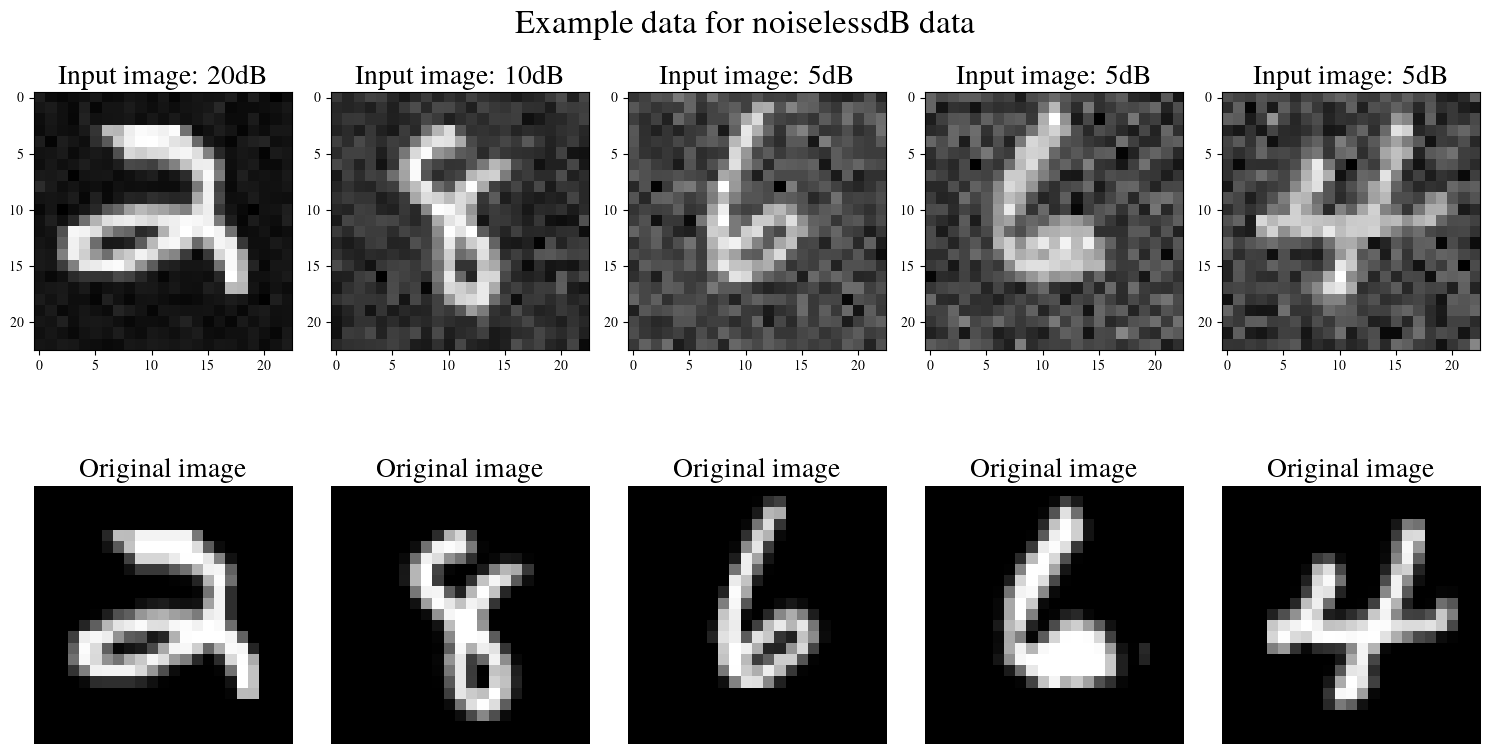

In [17]:
# Update plotting parameters
plt.rcParams.update({
    "figure.figsize" : [15,8.5],
})
label_size = 20
title_size = 24
# Printing 25 random images from the training dataset
train_data = []
for SNR in [1,5,10,20,30]:
    train_data = train_data + train_data_dict[f'train_data_{SNR}dB']
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    plt.imshow(train_data[idx][0][0].numpy(), cmap='gray')
    # plt.colorbar()
    plt.title(f'Input image: {train_data[idx][3]}', fontsize = label_size)
    plt.subplot(2, 5, count + 6)
    plt.imshow(train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image', fontsize = label_size)
    plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.suptitle(f"Example data for {snr}dB data", fontsize=title_size)
#plt.savefig(f"../figs/examples_{SNR}db_data.png")
plt.show()

# Evaluation of model on evaluation/test set

In [14]:
# Initialize counters
correct = 0
total = 0

# Initialize lists for storage
incorrect_examples = []
predicted_all = []
labels_all = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(loaders['eval']):
        # ----------- get images and labels -----------
        if len(data) == 3:
            # MNIST_mura dataset: [encoded image, original image, digit]
            images, _, labels = data
        elif len(data) == 4:
            # MNIST_mura_{SNR}dB dataset: [encoded image, original image, digit, noise level]
            images, _, labels, _ = data
        else: raise Exception("Make sure you are loading the correct data")
        
        # ----------- calculate outputs/preds -----------
        # calculate outputs by running images through the network (done in batches)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        idxs_mask = torch.nonzero(predicted != labels) #((predicted == labels) == False).nonzero()
        for single_sample in idxs_mask:
            incorrect_examples.append([np.squeeze(images[single_sample].numpy()), 
                                       labels[single_sample].numpy()[0], 
                                       predicted[single_sample].numpy()[0]])
        predicted_all.append(predicted.tolist())
        labels_all.append(labels.tolist())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

predicted_all = list(np.concatenate(predicted_all).flat) 
labels_all = list(np.concatenate(labels_all).flat) 

NameError: name 'loaders' is not defined

In [18]:
results = {}
print("Using model: ", params['model_save_path'])


for SNR in [1,5,10,20,30]:
    
    print(f"Getting results for SNR = {SNR}dB")
    results[f'predicted_{SNR}dB'], results[f'labels_{SNR}dB'], results[f'incorrect_examples_{SNR}dB'] = model.evaluate_model(model,loader_dict[f'loaders_{SNR}dB'])
    
print(f"Getting results for Noiseless")
results[f'predicted_noiseless'], results[f'labels_noiseless'], results[f'incorrect_examples_noiseless'] = model.evaluate_model(model,loader_dict[f'loaders_noiseless'])    

Using model:  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/models/classification/classification_OG_mnist_50epochs.pth
Getting results for SNR = 1dB
Accuracy of the network on the 7000 test images: 36.9 %
Getting results for SNR = 5dB
Accuracy of the network on the 7000 test images: 64.04285714285714 %
Getting results for SNR = 10dB
Accuracy of the network on the 7000 test images: 86.85714285714286 %
Getting results for SNR = 20dB
Accuracy of the network on the 7000 test images: 95.2 %
Getting results for SNR = 30dB
Accuracy of the network on the 7000 test images: 96.02857142857142 %
Getting results for Noiseless
Accuracy of the network on the 7000 test images: 96.35714285714286 %


## Confusion Matrix

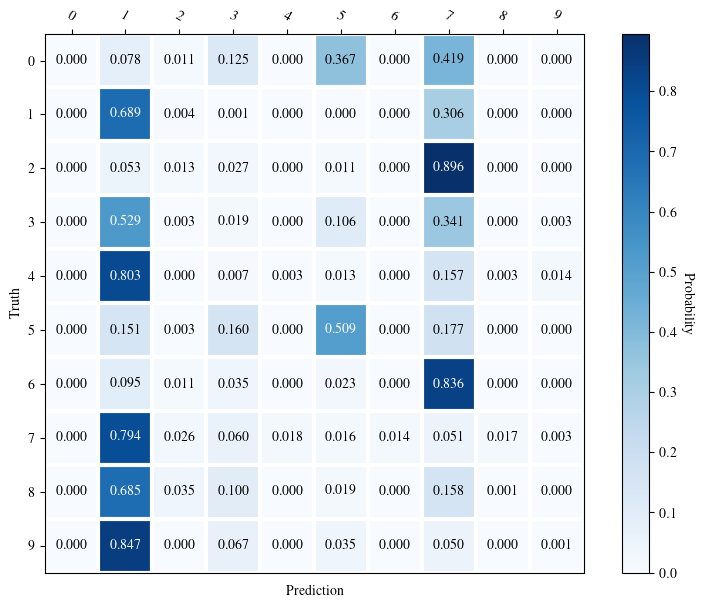

In [8]:
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")

## Class-specific accuracy

In [53]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        if len(data) == 3:
            images, _, labels = data
        elif len(data) == 4:
            # get images and labels from test set
            _, _, images, labels = data
        else: raise Exception("Make sure you are loading the correct data")
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.3f} %')

Accuracy for class:     0 is 98.872 %
Accuracy for class:     1 is 99.245 %
Accuracy for class:     2 is 96.523 %
Accuracy for class:     3 is 97.262 %
Accuracy for class:     4 is 96.687 %
Accuracy for class:     5 is 97.209 %
Accuracy for class:     6 is 98.688 %
Accuracy for class:     7 is 96.814 %
Accuracy for class:     8 is 97.529 %
Accuracy for class:     9 is 96.218 %


# Missclassifications

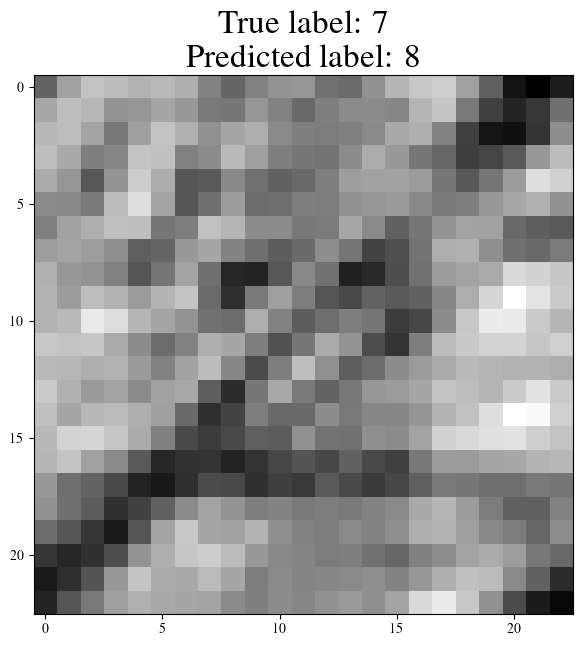

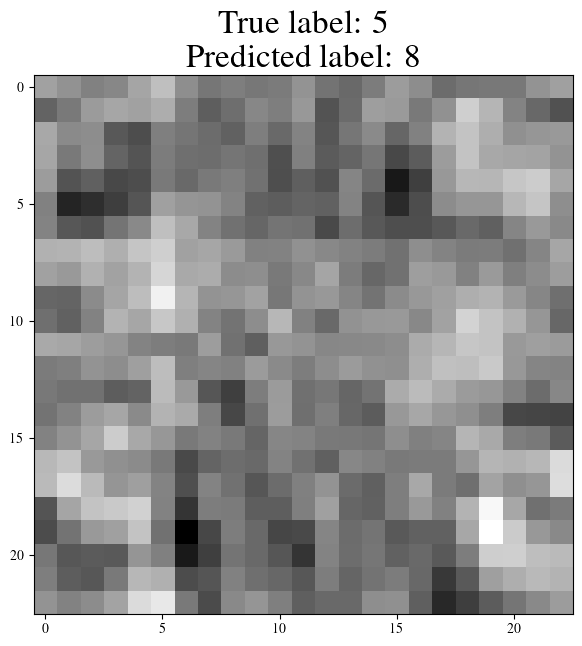

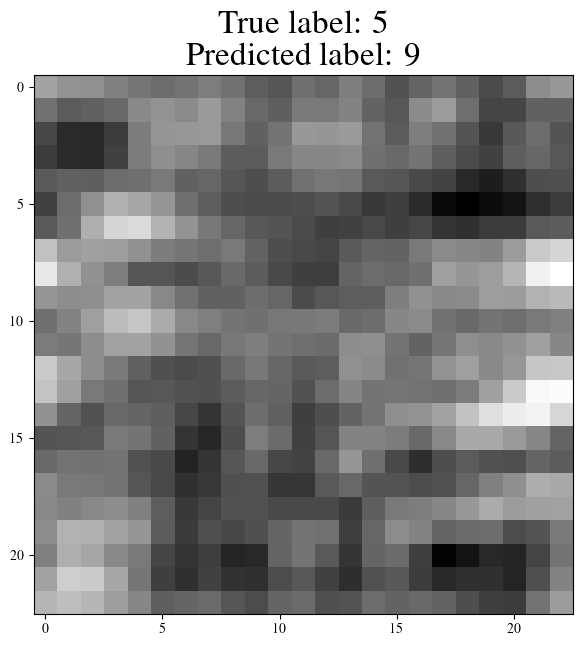

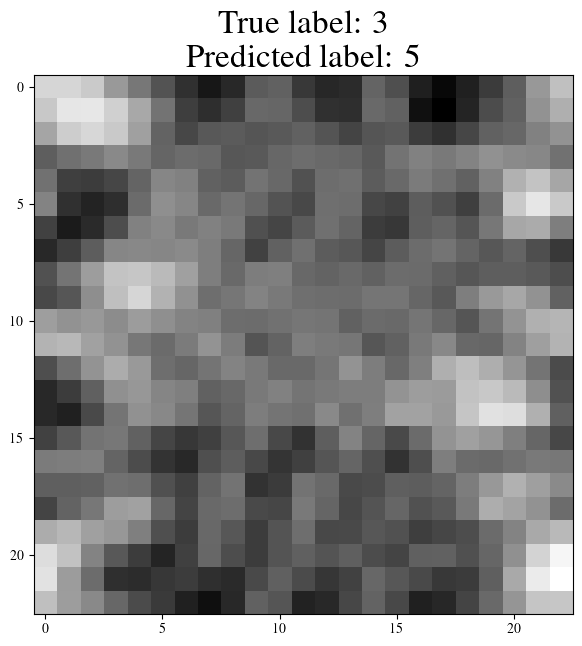

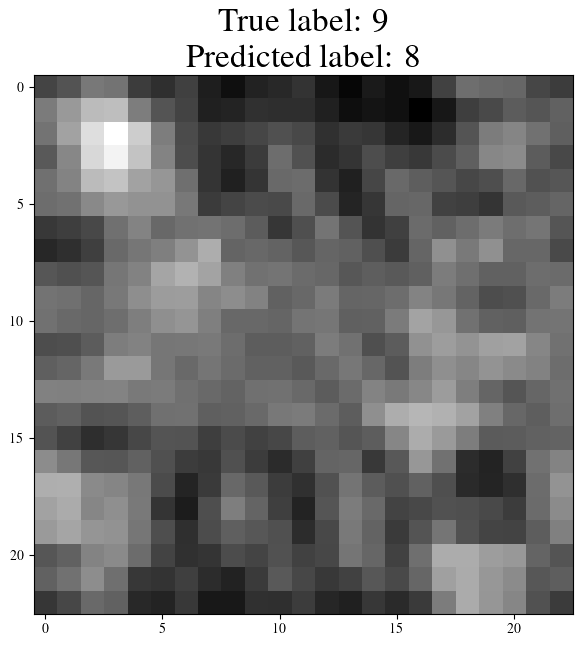

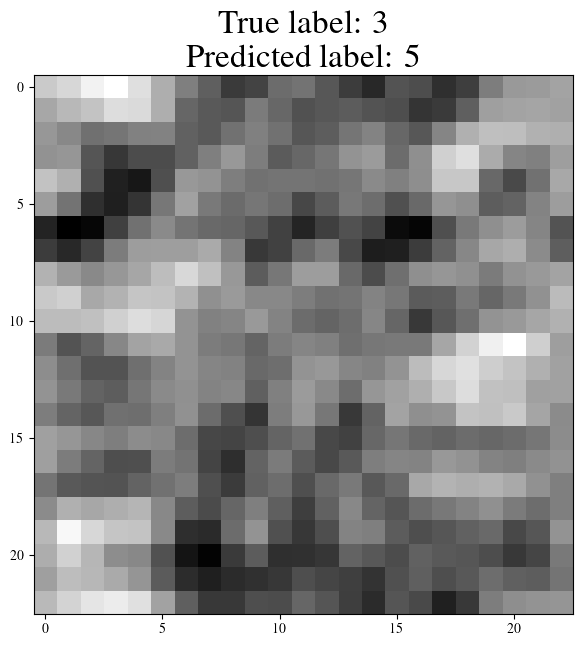

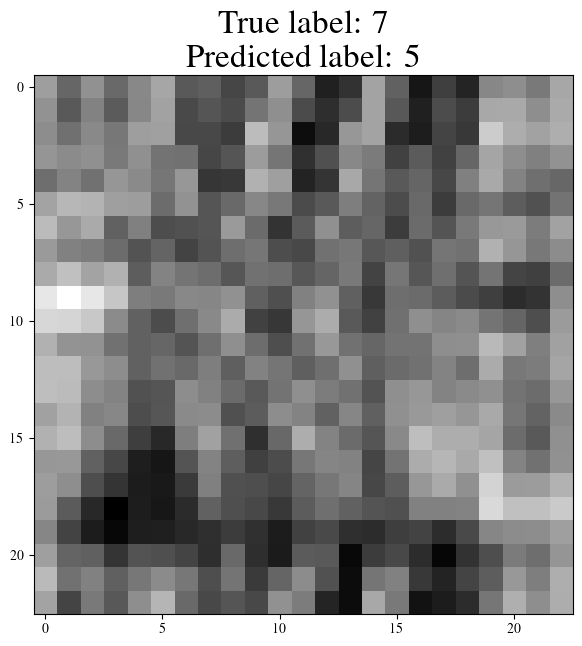

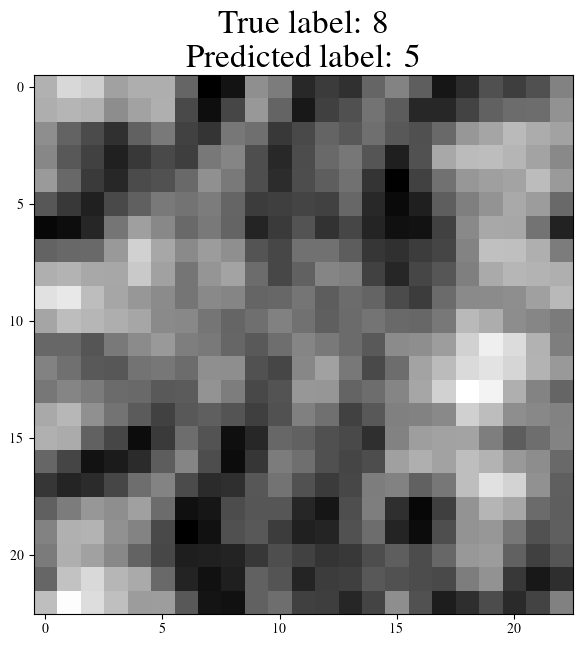

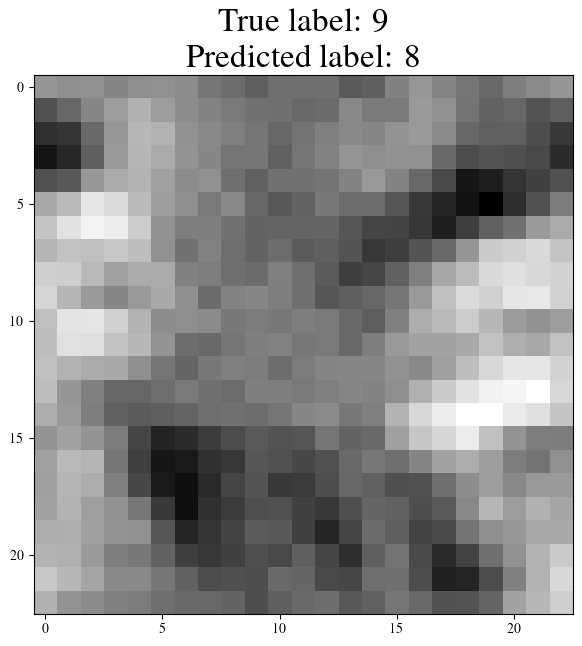

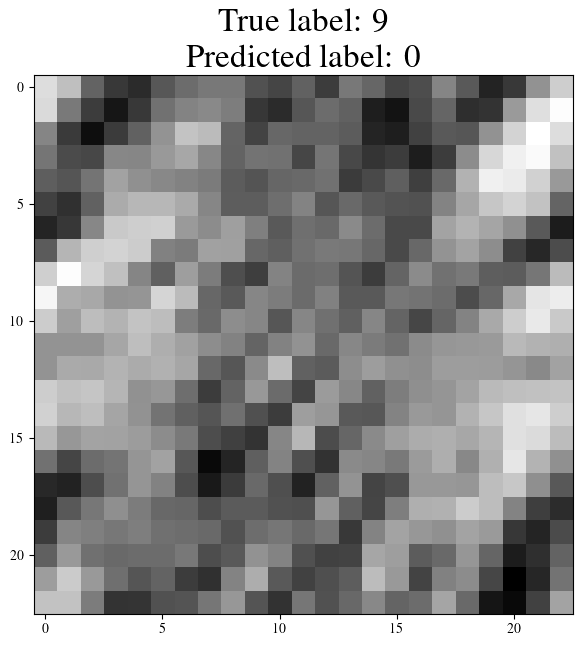

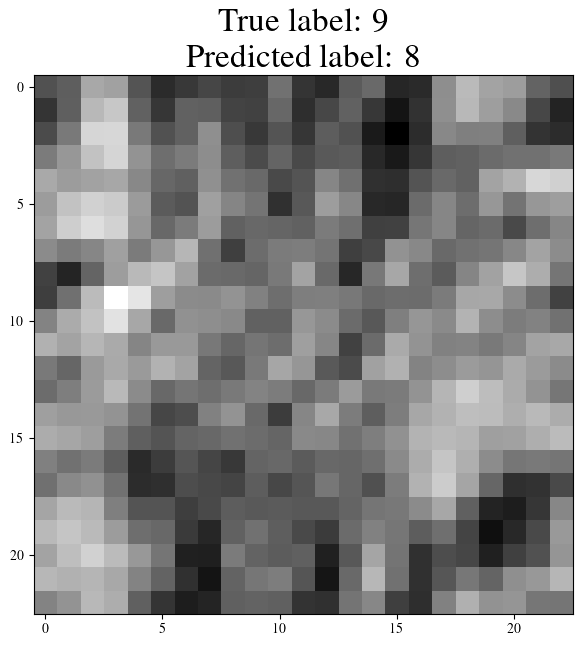

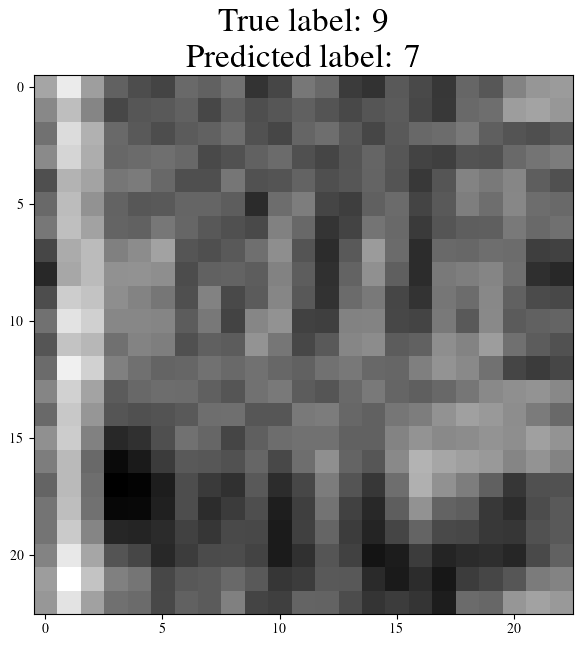

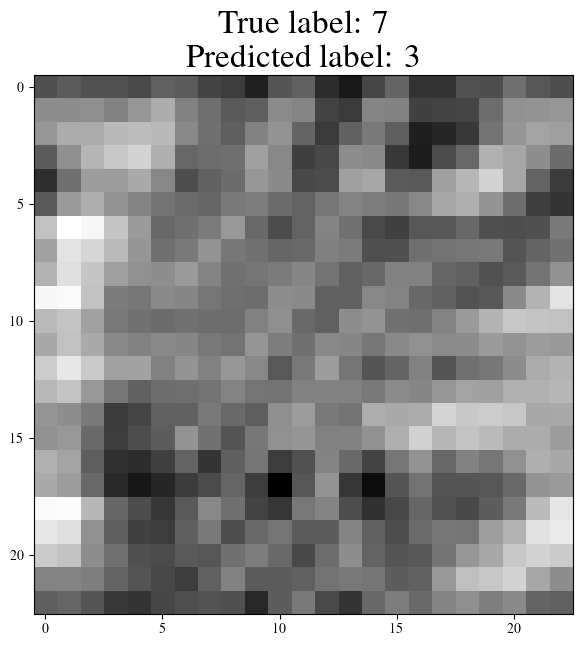

In [15]:
#index = 1
FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"

cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    img = np.squeeze(incorrect_examples[index][0])
    #true_img = mura.FFT_convolve(img, G)
    true_lab = incorrect_examples[index][1]
    pred_lab = incorrect_examples[index][2]

    if true_lab in [5,7,3,8,9]:
        #fig, axs = plt.subplots(2,1, figsize=(5,12))
        #axs = axs.ravel()
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs[0].imshow(true_img, cmap=cmap)
        axs.imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[0].set_title(f"Original Image", fontsize=24)
        #fig.savefig(FIG_FOLDER + f"misclass_encoded_{index}.png")
        plt.show() 

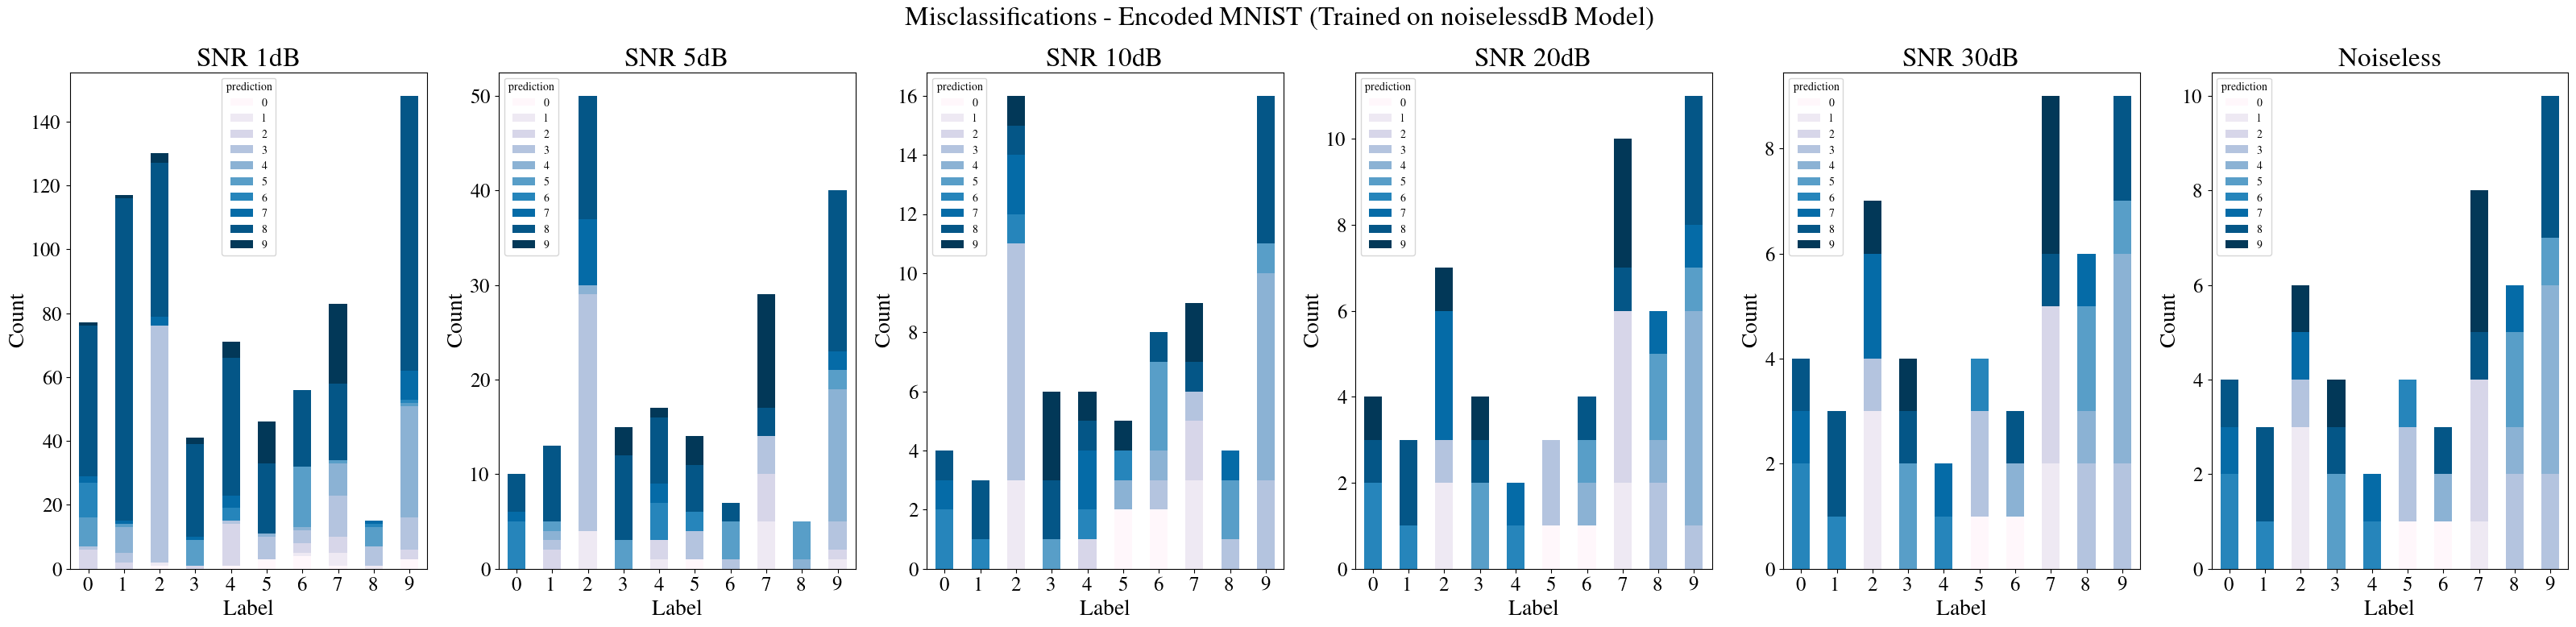

In [8]:
title_size = 24
tick_size  = 18
label_size = 20
fig, axs = plt.subplots(1,6, figsize=(40,8))
# Save dataframe with misclassifications
incorrect_examples = results[f'incorrect_examples_noiseless']
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])


crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu", ax=axs[5], fontsize=tick_size)
axs[5].set_ylabel("Count", fontsize=label_size)
axs[5].set_xlabel("Label", fontsize=label_size)
axs[5].set_title(f" Noiseless", fontsize=title_size)

for i, SNR in enumerate([1,5,10,20,30]):
    # Save dataframe with misclassifications
    incorrect_examples = results[f'incorrect_examples_{SNR}dB']
    df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])
    # print(f"{SNR}dB miclassified digits in order and percentage\n", df.label.value_counts(normalize=True))
    

    crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
    crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu", ax=axs[i], fontsize=tick_size)
    axs[i].set_ylabel("Count", fontsize=label_size)
    axs[i].set_xlabel("Label", fontsize=label_size)
    # axs[i].set_xticks(fontsize=tick_size)
    # axs[i].set_yticks(fontsize=tick_size)
    # axs[i].legend(fontsize=tick_size)
    axs[i].set_title(f" SNR {SNR}dB", fontsize=title_size)
    fig.suptitle(f"Misclassifications - Encoded MNIST (Trained on {params['SNR']}dB Model)", fontsize=title_size)
fig.savefig(f"../figs/{params['kind']}/{params['method']}_method/misclassifications_counts_trained_{params['model']}_model.png")
plt.show()
    # print(crosstab_misclass)

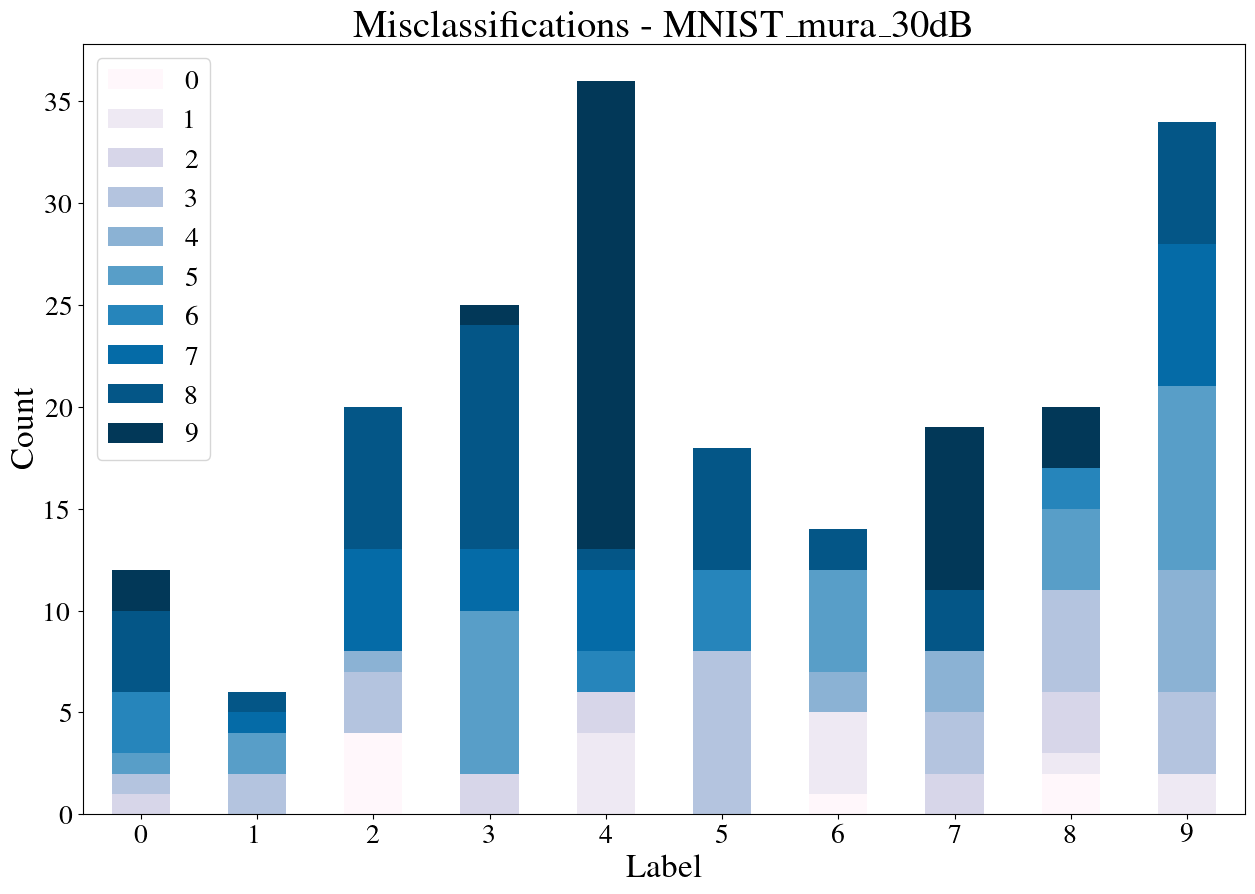

prediction  0  1  2  3  4  5  6  7   8   9
label                                     
0           0  0  1  1  0  1  3  0   4   2
1           0  0  0  2  0  2  0  1   1   0
2           4  0  0  3  1  0  0  5   7   0
3           0  0  2  0  0  8  0  3  11   1
4           0  4  2  0  0  0  2  4   1  23
5           0  0  0  8  0  0  4  0   6   0
6           1  4  0  0  2  5  0  0   2   0
7           0  0  2  3  3  0  0  0   3   8
8           2  1  3  5  0  4  2  0   0   3
9           0  2  0  4  6  9  0  7   6   0


In [11]:
title_size = 28
tick_size  = 20
label_size = 24

crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=label_size)
plt.xlabel("Label", fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.legend(fontsize=tick_size)
plt.title(f"Misclassifications - {params['dataset']}", fontsize=title_size)
#plt.savefig("../figs/misclassifications_counts_reconstructed_mnist.png")
plt.show()
print(crosstab_misclass)